# Bootstrapping

Parametric inference can be non-robust:

- inaccurate if parametric assumptions are violated
- if we rely on asymptotic results, we may not achieve an acceptable level of accuracy

Parmetric inference can be difficult:
- derivation of sampling distribution may not be possible

An alternative is to estimate the sampling distribution of a statistic **empirically** without making assumptions about the form of the population.

The bootstrap is a simulation tool for assessing accuracy. It is related to cross-validation, which we will encounter later in the course when we talk about tuning machine learning models.

This approach is most commonly used as a non-parametric method for calculating standard errors and confidence intervals. 

In [40]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

np.random.seed(42)

## The Jackknife

A simple precursor to bootstrapping is the jackknife (Quenouille 1949), which facilitates the estimation of the bias and variance of an estimator. Recall that the bias of an estimator $\widehat{\theta}$ of $\theta$ is:

$$Bias(\widehat{\theta}) = E(\widehat{\theta}) - \theta$$

Consider calculating an estimate using $n-1$ values from the dataset $\widehat{\theta}_{(-i)}$ (that is, the $i^{th}$ value is removed). If this is repeated for each $i=1,\ldots,n$ observation, we can average them to obtain:

$$\bar{\theta}_{(n)} = n^{-1} \sum_i \widehat{\theta}_{(-i)}$$

The **jackknife bias estimate** is:

$$b_{jack} = (n-1)(\bar{\theta}_{(n)} - \widehat{\theta})$$

It can be shown that $b_{jk}$ estimates the bias up to order $O(n^{−2})$.

In [41]:
def jackknife_bias(data, func, **kwargs):
    theta_hat = func(data, **kwargs)
    n = data.shape[0]
    idx = np.arange(n)
    theta_jack = np.sum(func(data[idx!=i], **kwargs) for i in range(n))/n
    return (n-1) * (theta_jack - theta_hat)

In [42]:
x = np.random.normal(0, 2, 100)

In [43]:
np.std(x)

1.8072323532892591

In [44]:
np.std(x) - jackknife_bias(x, np.std)

1.8207199660417399

Thus, a bias-corrected estimator is:

$$\widehat{\theta}_{jack} = \widehat{\theta} - b_{jack}$$

Another way of expressing $\widehat{\theta}_{jack}$ is:

$$\widehat{\theta}_{jack} = (n^{-1}) \sum_i  \widetilde{\theta}_i$$

where $\widetilde{\theta}_i$ are known as **pseudovalues** and are defined as:

$$\widetilde{\theta}_i = n \widehat{\theta} - (n-1) \widehat{\theta}_{(-i)}$$

In [45]:
def jackknife(data, func, **kwargs):
    theta_hat = func(data, **kwargs)
    n = data.shape[0]
    idx = np.arange(n)
    return np.sum(n*theta_hat - (n-1)*func(data[idx!=i], **kwargs) for i in range(n))/n

In [60]:
jackknife(x, np.std)

1.8207199660417088

Correspondingly, the **jackknife variance estimate** of the estimator $\widehat{\theta}$ is:

$$v_{jack} = \frac{\widetilde{s}^2}{n}$$

where $\widetilde{s}^2$ is the sample variance of the pseudo-values:

$$\widetilde{s}^2 = \frac{\sum_i (\widetilde{\theta}_i - n^{-1}\sum_i \widetilde{\theta}_i)^2}{n-1}$$

Under certain regularity conditions, $v_{jack}$ is a consistent estimator of $V(\widehat{\theta})$.

### Exercise

Write a function that implements a jackknife variance estimator.

In [57]:
# write your answer here

## The Bootstrap

The bootstrap is a resampling method discovered by [Brad Efron](http://www.jstor.org/discover/10.2307/2958830?uid=3739568&uid=2&uid=4&uid=3739256&sid=21102342537691) that allows one to approximate the true sampling distribution of a dataset, and thereby obtain estimates of the mean and variance of some function of the distribution.

In general, consider a statistic $T_n = g(X_1, \ldots, X_n)$, which has variance $V_F(T_n)$. Note this implies that the variance is a function of the underlying $F$, which is unknown. 

One approach is to estimate $V_F(T_n)$ with some $V_{F_n}(T_n)$, which is a plug-in estimator of the variance. But, $V_{F_n}(T_n)$ may be difficult to compute, so we can attempt to approximate it with a **simulation estimate** $V_{boot}$. 

Here is the algorithm:

1. Draw $X_{1}^*, \ldots, X_{n}^* \sim \widehat{F}_n$
2. For each r in R iterations: 
    Calculate statistic $T^*_{rn} = g(X^*_{r1}, \ldots, X^*_{rn})$
3. Calculate variance: $V_{boot} = \frac{1}{R} \sum_r \left(T^*_{rn} - \bar{T}^*_{.n} \right)^2$

Rather than finding a way of drawing $n$ points at random from $\widehat{F}_n$, we can instead draw a sample of size $n$ **with replacement from the original data**. So, step 1 can be modified to:

> 1. Draw $X_{1}^*, \ldots, X_{n}^*$ with replacement from $X_{1}, \ldots, X_{n}$


These are called **bootrstrap samples**:

<div style="font-size: 120%;">  
$$S_1^* = \{X_{11}^*, X_{12}^*, \ldots, X_{1n}^*\}$$
</div>

We regard S as an "estimate" of population P

> population : sample :: sample : bootstrap sample

To generate samples with replacement in Python, there are a handful of approaches. We can use NumPy to generate random integers (`np,random.randint`), and use these to index DataFrame rows with `iloc`.

In [61]:
prostate_data = pd.read_table('../data/prostate.data.txt', index_col=0)
prostate_data.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


In [62]:
random_ind = np.random.randint(0, prostate_data.shape[0], 5)
prostate_data.iloc[random_ind]

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
9,-0.776529,3.539509,47,-1.386294,0,-1.386294,6,0,1.047319,F
62,1.997418,3.719651,63,1.619388,1,1.909542,7,40,2.853592,F
37,1.423108,3.657131,73,-0.579819,0,1.658228,8,15,2.157559,T
97,3.471966,3.974998,68,0.438255,1,2.904165,7,20,5.582932,F
51,1.091923,3.993603,68,-1.386294,0,-1.386294,7,50,2.656757,T


NumPy's `random.choice` function makes this even easier, and allows for custom sampling probabilities when non-uniform sampling is desired.

In [17]:
np.random.choice(prostate_data.index, 5)

array([70, 56, 95, 97, 38])

In [18]:
prostate_data.loc[np.random.choice(prostate_data.index, 5)]

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
58,0.463734,3.764682,49,1.423108,0,-1.386294,6,0,2.794228,T
60,1.061257,3.851211,61,1.294727,0,-1.386294,7,40,2.812410,T
72,1.160021,3.341093,77,1.749200,0,-1.386294,7,25,3.037354,T
4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
20,0.182322,3.825375,70,1.658228,0,-1.386294,6,0,1.599388,T


### Exercise

Generate 20 samples with replacement from the prostate dataset, weighting samples inversely by age.

In [ ]:
# Write your answer here

As of pandas version 0.16.1, resampling data from a DataFrame became even easier with the addition of the `sample` method.

In [19]:
prostate_data.sample(20, replace=True)

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
76,3.141130,3.263849,68,-0.051293,1,2.420368,7,50,3.337547,T
87,2.024193,3.731699,58,1.638997,0,-1.386294,6,0,3.680091,T
79,2.648300,3.582129,69,-1.386294,1,2.583998,7,70,3.457893,T
20,0.182322,3.825375,70,1.658228,0,-1.386294,6,0,1.599388,T
75,2.999226,3.849083,69,-1.386294,1,1.909542,7,20,3.275256,T
52,1.660131,4.234831,64,2.073172,0,-1.386294,6,0,2.677591,T
50,1.220830,3.568123,70,1.373716,0,-0.798508,6,0,2.591516,F
72,1.160021,3.341093,77,1.749200,0,-1.386294,7,25,3.037354,T
29,1.040277,3.128951,67,0.223144,0,0.048790,7,80,1.848455,T
6,-1.049822,3.228826,50,-1.386294,0,-1.386294,6,0,0.765468,T


### Bootstrap Estimates

From our bootstrapped samples, we can extract *estimates* of the expectation and its variance:

$$\bar{T}^* = \hat{E}(T^*) = \frac{\sum_r T_r^*}{R}$$

$$\hat{\text{Var}}(T^*) = \frac{\sum_r (T_r^* - \bar{T}^*)^2}{R-1}$$



## Bootstrap Confidence Intervals

There are a handful of ways for constructing confidence intervals from bootstrap samples, varying in ease of calculation and accuracy.

### Bootstrap Normal Interval

Perhaps the simplest bootstrap interval is the normal interval:

$$T_n ± z_{α/2} \widehat{SE}_{boot}$$

where $\widehat{SE}_{boot}$ is an estimate of the standard error using the bootstrap sample. Of course, this interval is not accurate unless the distribution of $T_n$ is close to Gaussian.


We can first define a **pivotal interval**. Let $\theta = T(F)$ and $\widehat{\theta}_n = T(\widehat{F}_n)$, and further define $P_n = \widehat{θ}_n − θ$. 

Let $H(p)$ denote the CDF of the pivot:

$$H(p) = Pr_F(P_n \le p)$$.

Now define the interval $C_n = (a, b)$ where:

$$\begin{eqnarray}
a &=& \widehat{\theta}_n − H^{−1}(1−\alpha/2) \\
b &=& \widehat{\theta}_n − H^{−1}(\alpha/2).
\end{eqnarray}$$

It can be shown that $C_n$ is an exact $1 − \alpha$ confidence interval for $\theta$. But clearly, $a$ and $b$ depend on the unknown $H$. However, we can form a bootstrap estimate of H:

$$\widehat{H}_P = \frac{1}{R} \sum_r I\left[(\widehat{\theta}_{nr} - \widehat{\theta}_{n.}) < p\right]$$

From this, an approximate $1-\alpha$ confidence interval is $C_n = (\widehat{a}, \widehat{b})$:

$$\begin{eqnarray}
\widehat{a} &=& \widehat{\theta}_n − \widehat{H}^{−1}(1−\alpha/2) = 2\widehat{\theta}_n - \theta^*_{1 - \alpha/2}\\
\widehat{b} &=& \widehat{\theta}_n − \widehat{H}^{−1}(\alpha/2) = 2\widehat{\theta}_n - \theta^*_{\alpha/2}.
\end{eqnarray}$$



In [85]:
weights = prostate_data.lweight.copy()
n = weights.shape[0]
weights.mean()

3.6289426597938146

In [102]:
R = 100000
samples = np.array([weights.sample(n, replace=True) for r in range(R)])

In [103]:
samples.shape

(100000, 97)

In [104]:
estimates = samples.mean(0)

In [105]:
2*estimates.mean() - np.percentile(estimates, [97.5, 2.5])

array([ 3.62665214,  3.63159947])

An alternative approach for calculating a pivotal interval is to define:

$$Z_n = \frac{T_n - \theta}{\widehat{SE}_{boot}}$$

and 

$$Z^*_{nr} = \frac{T^*_{nr} - T_n}{\widehat{SE}^*_{boot}}$$

where $\widehat{SE}^*_{boot}$ is the standard error of $T^*_{nr}$.

Here, the quantiles of $Z^*_{n1}, \ldots, Z^*_{nR}$ should approximate the true quantiles of the distribution of $Z_n$. We can then calculate the following interval:

$$C_n = (T_n - z^*_{1-\alpha/2}\widehat{SE}_{boot}, T_n - z^*_{\alpha/2}\widehat{SE}_{boot})$$

This is a **studentized pivotal interval**.

This interval is more computationally-intensive because $\widehat{SE}^*_{boot}$ has to be calculated for each bootstrap sample, but it has better accuracy than the non-studentized interval.

### Bootstrap Percentile Intervals

An even simpler interval involves using the empirical quantiles of the bootstrapped statistics. Consider a monotone transformation $U = m(T)$ such that $U \sim N(m(\theta), c^2)$. Importantly, we don't need to know what $m$ is, only that it exists. If we let $U^*_r = m(T^*_r)$, then $U^*_{(R\alpha/2)} = m(T^*_{(R\alpha/2)})$ because the monotone transformation preserves the quantiles.

Since $U \sim N(m(\theta), c^2)$, the $\alpha/2$ quantile of $U$ is $m(\theta) - z_{\alpha/2} c$. From this, it can be shown that:

$$Pr(T^*_{R\alpha/2} \le \theta \le T^*_{R(1 - \alpha/2)}) = Pr\left( -z_{\alpha/2} \le \frac{U - m(T)}{c} \le z_{\alpha/2} \right) = 1 - \alpha$$

This employs the *ordered* bootstrap replicates:

$$T_{(1)}^*, T_{(2)}^*, \ldots, T_{(R)}^*$$

Simply extract the $100(\alpha/2)$ and $100(1-\alpha/2)$ percentiles:

$$T_{[(R+1)\alpha/2]}^* \lt \theta \lt T_{[(R+1)(1-\alpha/2)]}^*$$

In [106]:
prostate_data.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


In [108]:
data_subset = prostate_data[['lcavol', 'lweight', 'lbph', 'lcp', 'lpsa']]

In [122]:
bootstrap_data = (data_subset.sample(data_subset.shape[0], replace=True) for _ in range(1000))

In [123]:
from sklearn.linear_model import LinearRegression

In [125]:
regmod = LinearRegression()

coefs = np.empty((1000, 4))

for i,X in enumerate(bootstrap_data):
    y = X.pop('lpsa')
    regmod.fit(X, y)
    coefs[i] = regmod.coef_

In [128]:
coefs.mean(0)

array([ 0.58584577,  0.5856547 ,  0.0542766 ,  0.08932877])

In [129]:
coefs.sort(axis=0)

In [131]:
boot_se = coefs[[25, 975], :].T

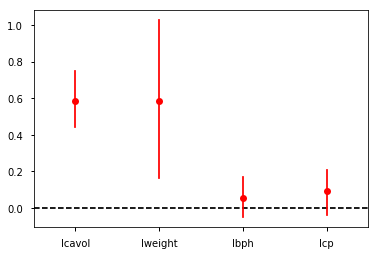

In [135]:
coef_means = coefs.mean(0)
plt.plot(coef_means, 'ro')
for i in range(len(coef_means)):
    plt.errorbar(x=[i,i], y=boot_se[i], color='red')
plt.xlim(-0.5, 3.5)
plt.xticks(range(len(coef_means)), ['lcavol', 'lweight', 'lbph', 'lcp'])
plt.axhline(0, color='k', linestyle='--')

## References

Wasserman, L. (2006). All of Nonparametric Statistics. Springer Science & Business Media.